In [127]:
# Data util
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
from pprint import pprint

# Statistical Tests
from scipy.stats import kstest
from scipy import stats

# Global Declarations (and naming convention)

In [128]:
# So the script can be easily reused for other tags in future analyses
tag_1 = "reactjs"
tag_2 = "angular"

# ques_df -> questions dataframe
# ans_df -> answers_dataframe
# post_df -> ques_df + ans_df
# tag_x_[ques|ans|post]_df -> related dataframe for that specific tag

# Load Dataset

In [129]:
questions_file = "./posts_questions_{}_{}_bigquery.csv".format(tag_1,tag_2)
answers_file = "posts_answers_{}_{}_bigquery.csv".format(tag_1,tag_2)

In [130]:
# a global dictionary of dataframes
dataframes = {
    "ques_df": pd.read_csv(questions_file),
    "ans_df": pd.read_csv(answers_file)
}

In [131]:
pprint(dataframes["ques_df"].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388930 entries, 0 to 388929
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   id                             388930 non-null  int64  
 1   title                          388930 non-null  object 
 2   body                           388930 non-null  object 
 3   accepted_answer_id             166974 non-null  float64
 4   answer_count                   388930 non-null  int64  
 5   comment_count                  388930 non-null  int64  
 6   community_owned_date           0 non-null       float64
 7   creation_date                  388930 non-null  object 
 8   favorite_count                 65792 non-null   float64
 9   last_activity_date             388930 non-null  object 
 10  last_edit_date                 179124 non-null  object 
 11  last_editor_display_name       2494 non-null    object 
 12  last_editor_user_id           

In [132]:
pprint(dataframes["ans_df"].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474551 entries, 0 to 474550
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        474551 non-null  int64  
 1   title                     0 non-null       float64
 2   body                      474551 non-null  object 
 3   accepted_answer_id        0 non-null       float64
 4   answer_count              0 non-null       float64
 5   comment_count             474551 non-null  int64  
 6   community_owned_date      344 non-null     object 
 7   creation_date             474551 non-null  object 
 8   favorite_count            0 non-null       float64
 9   last_activity_date        474551 non-null  object 
 10  last_edit_date            130588 non-null  object 
 11  last_editor_display_name  619 non-null     object 
 12  last_editor_user_id       129984 non-null  float64
 13  owner_display_name        2520 non-null    o

# Data Preprocessing and Basic transformation

In [133]:
# conceptually stack overflow answers don't have tags, only respective questions do (for answer posts this is the parent_tags column)
dataframes["ans_df"][dataframes["ans_df"]["tags"].notna()]

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,...,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count,parent_tags


In [134]:
# for simplification of filtering, lets put contents of parent_tags into tags
dataframes["ans_df"]["tags"] = dataframes["ans_df"]["parent_tags"]

In [135]:
# New metric -- engagement_count = answer_count + comment_count
dataframes["ques_df"]["engagement_count"] = dataframes["ques_df"]["comment_count"] + dataframes["ques_df"]["answer_count"]

# Answer posts don't have answers so engagement_count = comment_count
dataframes["ans_df"]["engagement_count"] = dataframes["ans_df"]["comment_count"]

In [136]:
# New metric -- time_to_accepted_answer (in hours)
dataframes["ques_df"]['accepted_answer_creation_date'] = pd.to_datetime(dataframes["ques_df"]['accepted_answer_creation_date'])
dataframes["ques_df"]['creation_date'] = pd.to_datetime(dataframes["ques_df"]['creation_date'])
dataframes["ques_df"]['time_to_accepted_answer'] = (dataframes["ques_df"]['accepted_answer_creation_date'] - dataframes["ques_df"]['creation_date']).astype('timedelta64[h]')

In [137]:
# New feature -- group_name (to mark the analysis groups for comparing distributions)
tag_1_ques_df = dataframes["ques_df"][dataframes["ques_df"]['tags'].str.contains(tag_1, case=False)]
tag_1_ans_df = dataframes["ans_df"][dataframes["ans_df"]['tags'].str.contains(tag_1, case=False)]
tag_1_ans_df.loc[:, "group_name"] = tag_1_ques_df.loc[:, "group_name"] = str(tag_1)

tag_2_ques_df = dataframes["ques_df"][dataframes["ques_df"]['tags'].str.contains(tag_2, case=False)]
tag_2_ans_df = dataframes["ans_df"][dataframes["ans_df"]['tags'].str.contains(tag_2, case=False)]
tag_2_ans_df.loc[:, "group_name"] = tag_2_ques_df.loc[:, "group_name"] = str(tag_2)


C:\Users\muham\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\muham\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [138]:
# update combined ques and ans_df with group_name column
ques_df = pd.concat([tag_1_ques_df, tag_2_ques_df])
ans_df = pd.concat([tag_1_ans_df, tag_2_ans_df])
dataframes.update({
    'ques_df': ques_df,
    'ans_df': ans_df,

    # combine global questions and answers dataset
    'post_df': pd.concat([ques_df, ans_df]),
    # generate posts dataframes for tags by filtering
    f"{tag_1}_post_df": pd.concat([tag_1_ques_df, tag_1_ans_df]),
    f"{tag_2}_post_df": pd.concat([tag_2_ques_df, tag_2_ans_df]),
    
    # generate ques and ans dataframe by filtering
    f"{tag_1}_ques_df": tag_1_ques_df,
    f"{tag_1}_ans_df": tag_1_ans_df,

    f"{tag_2}_ques_df": tag_2_ques_df,
    f"{tag_2}_ans_df": tag_2_ans_df,
})

In [139]:
# dataframes produced
list(dataframes.keys())

['ques_df',
 'ans_df',
 'post_df',
 'reactjs_post_df',
 'angular_post_df',
 'reactjs_ques_df',
 'reactjs_ans_df',
 'angular_ques_df',
 'angular_ans_df']

# Exploratory Data Analysis

In [140]:
pprint("Total number of questions for both tags in time frame: {}".format(len(dataframes["ques_df"])))
pprint("Total number of answers for both tags in time frame: {}".format(len(dataframes["ans_df"])))

'Total number of questions for both tags in time frame: 390069'
'Total number of answers for both tags in time frame: 475955'


In [141]:
pprint(f"Total number of {tag_1} questions in time frame: {len(dataframes[f'{tag_1}_ques_df'])}")
pprint(f"Total number of {tag_2} questions in time frame: {len(dataframes[f'{tag_2}_ques_df'])}")

pprint(f"Total number of {tag_1} answers in time frame: {len(dataframes[f'{tag_1}_ans_df'])}")
pprint(f"Total number of {tag_2} answers in time frame: {len(dataframes[f'{tag_2}_ans_df'])}")

'Total number of reactjs questions in time frame: 368804'
'Total number of angular questions in time frame: 21265'
'Total number of reactjs answers in time frame: 456030'
'Total number of angular answers in time frame: 19925'


Angular posts are approximately half that of react posts

In [142]:
# Get statisical summary of key metrics
for tag in [tag_1, tag_2]:
    for post_type in ["ques", "ans"]:
        pprint(f"{tag} {post_type} statistical summary of key metrics")
        pprint(dataframes[f'{tag}_{post_type}_df'][["answer_count", "comment_count", "favorite_count", "score", "view_count"]].describe())

'reactjs ques statistical summary of key metrics'
        answer_count  comment_count  favorite_count          score  \
count  368804.000000  368804.000000    64288.000000  368804.000000   
mean        1.236510       1.718902        1.999798       1.628713   
std         1.226386       2.376387        8.429546      12.423346   
min         0.000000       0.000000        0.000000     -15.000000   
25%         1.000000       0.000000        1.000000       0.000000   
50%         1.000000       1.000000        1.000000       0.000000   
75%         2.000000       3.000000        1.000000       1.000000   
max        76.000000      41.000000      630.000000    1969.000000   

         view_count  
count  3.688040e+05  
mean   1.914812e+03  
std    1.348271e+04  
min    3.000000e+00  
25%    5.300000e+01  
50%    1.870000e+02  
75%    8.470000e+02  
max    1.313193e+06  
'reactjs ans statistical summary of key metrics'
       answer_count  comment_count  favorite_count          score  view_

In [143]:
# # Percentage of questions with answers
def _compute_presence_percentage(df, field): 
    count = len(df[df[field].notna() & df[field] > 0])
    return count/len(df) * 100

tag_1_answers_percent = _compute_presence_percentage(dataframes[f'{tag_1}_ques_df'], 'answer_count')
tag_2_answers_percent = _compute_presence_percentage(dataframes[f'{tag_2}_ques_df'], 'answer_count')

pprint(f"Percentage of {tag_1} questions with answers: {tag_1_answers_percent}")
pprint(f"Percentage of {tag_2} questions with answers: {tag_2_answers_percent}")

'Percentage of reactjs questions with answers: 57.824210149564536'
'Percentage of angular questions with answers: 53.61391958617446'


In [144]:
# # Percentage of questions with accepted answers
tag_1_accepted_answers_percent = _compute_presence_percentage(dataframes[f'{tag_1}_ques_df'], 'accepted_answer_id')
tag_2_accepted_answers_percent = _compute_presence_percentage(dataframes[f'{tag_2}_ques_df'], 'accepted_answer_id')

pprint(f"Percentage of {tag_1} questions with accepted answers: {tag_1_accepted_answers_percent}")
pprint(f"Percentage of {tag_2} questions with accepted answers: {tag_2_accepted_answers_percent}")

'Percentage of reactjs questions with accepted answers: 43.43309725491047'
'Percentage of angular questions with accepted answers: 33.88666823418763'


# Metric Selection/Extraction

In [145]:
# Select only columns of interest
columns_to_select = ["id", "post_type_id", "group_name", "score", "answer_count", "comment_count", "view_count", "time_to_accepted_answer"]
analysis_dataset_tag_1 = dataframes[f"{tag_1}_post_df"][columns_to_select]
analysis_dataset_tag_2 = dataframes[f"{tag_2}_post_df"][columns_to_select]

In [146]:
analysis_dataset_tag_1.head()

,id,post_type_id,group_name,score,answer_count,comment_count,view_count,time_to_accepted_answer
0,64324130,1,reactjs,-2,1.0,4,84.0,NaN
1,54401691,1,reactjs,3,1.0,0,84.0,NaN
2,59494718,1,reactjs,1,0.0,1,84.0,NaN
3,54080422,1,reactjs,0,2.0,0,84.0,3.0
4,56661959,1,reactjs,-1,2.0,5,84.0,0.0


In [147]:
# Export
analysis_dataset_tag_1.to_csv(f"{tag_1}_analysis_dataset.csv", sep=",")
analysis_dataset_tag_2.to_csv(f"{tag_2}_analysis_dataset.csv", sep=",")

# Metric Distribution Analysis

In [148]:
# Helper function to plot seaborn "distplots" which combine histograms with a kernel density estimate plot 
# to visualize the distribution. Y-axis is PDE - probability density estimate and the histogram represent (visually)
# the frequency count
def plot_distribution(df, metric, tag="", x_label_type="Questions", figsize=(20,5), xticks_arr=[], kde_kws={}):
    score_dist_fig, ax =plt.subplots(1,1, figsize=figsize)
    ax.set(ylabel='Density (PDE)')
    distplot = sns.distplot(df[metric], axlabel=f"{tag} {x_label_type} {metric}", ax=ax, rug=False, kde_kws=kde_kws)
    if len(xticks_arr)>0:
        plt.xticks(xticks_arr)
    plt.show()
    return distplot

## Metric 1: Score (number_upvotes - number_downvotes)

Note: for the 1st metric analysis, code statements will be made step-by-step and for subsequent metrics more concise higher level functions will be called

In [149]:
# Set current metric being analyzed
metric = "score"

### M1.1 reactjs score

'Raw score distribution for reactjs questions'


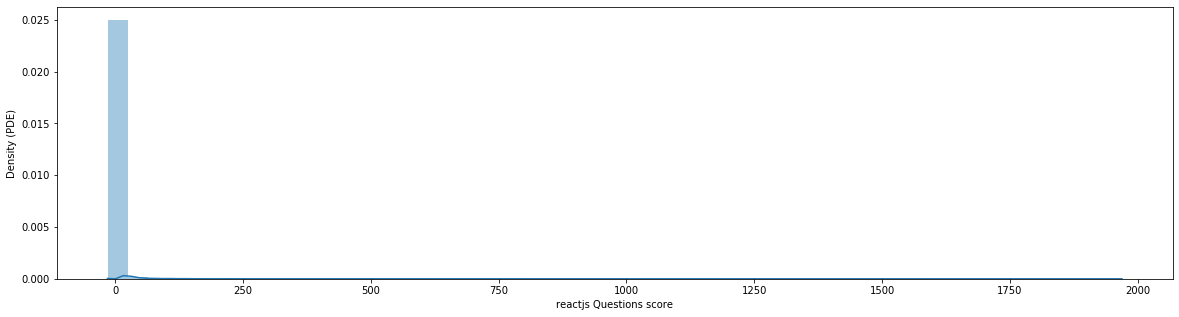

'Raw score distribution for reactjs answers'


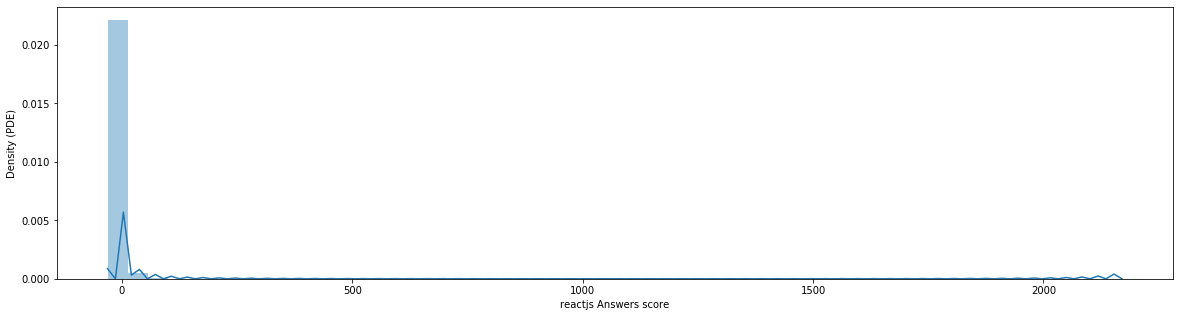

In [150]:
pprint(f'Raw {metric} distribution for {tag_1} questions')
plot_distribution(dataframes[f'{tag_1}_ques_df'], metric, tag_1)

pprint(f'Raw {metric} distribution for {tag_1} answers')
plot_distribution(dataframes[f'{tag_1}_ans_df'], metric, tag_1, "Answers")

- Large range of values and outliers makes it difficult to interpret results visually and know which distribution. 
- Lets remove outliers using interquartile range (IQR) rather than standard deviation as removal using std. dev. assumes its a normal distribution

In [151]:
def get_outlier_limits_iqr(df, metric):
    q1 = df[metric].quantile(0.25)
    q3 = df[metric].quantile(0.75)
    iqr = q3-q1
    upper_limit = q3 + 1.5 * iqr
    lower_limit = q1 - 1.5 * iqr
    return upper_limit, lower_limit

In [152]:
upper_limit, lower_limit = get_outlier_limits_iqr(dataframes[f'{tag_1}_ques_df'], metric)
no_outlier_ques_df = dataframes[f'{tag_1}_ques_df'][(dataframes[f'{tag_1}_ques_df'][metric] > lower_limit) & (dataframes[f'{tag_1}_ques_df'][metric] < upper_limit)]

upper_limit, lower_limit = get_outlier_limits_iqr(dataframes[f'{tag_1}_ans_df'], metric)
no_outlier_ans_df = dataframes[f'{tag_1}_ans_df'][(dataframes[f'{tag_1}_ans_df'][metric] > lower_limit) & (dataframes[f'{tag_1}_ans_df'][metric] < upper_limit)]


'No-outlier score distribution for reactjs questions'


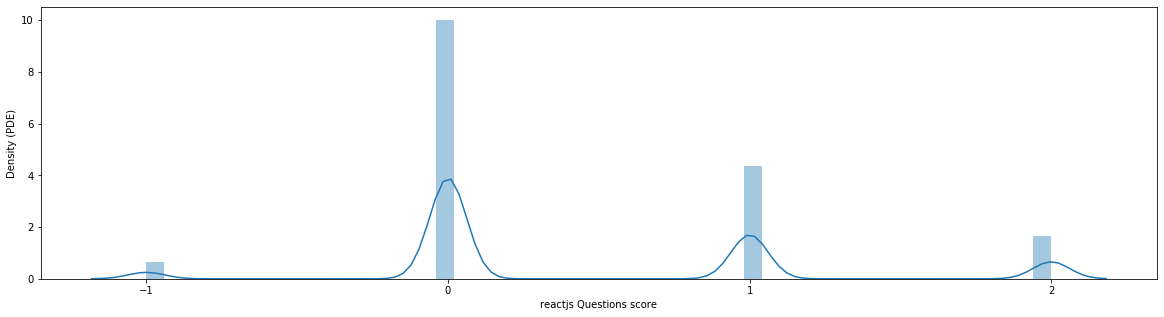

'No-outlier score distribution for reactjs answers'


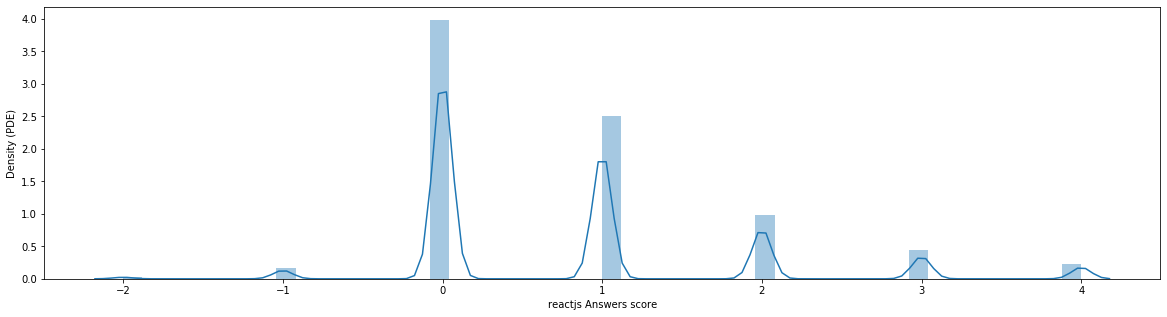

In [153]:
pprint(f'No-outlier {metric} distribution for {tag_1} questions')
# scores can only be whole numbers by definition. Lets ensure that is depicted on the x-axis
xticks_arr = np.arange(min(no_outlier_ques_df[metric]), max(no_outlier_ques_df[metric])+1, 1)
plot_distribution(no_outlier_ques_df, metric, tag_1, figsize=(20,5), xticks_arr=xticks_arr)

pprint(f'No-outlier {metric} distribution for {tag_1} answers')
xticks_arr = np.arange(min(no_outlier_ans_df[metric]), max(no_outlier_ans_df[metric])+1, 1)
plot_distribution(no_outlier_ans_df, metric, tag_1, "Answers", (20,5), xticks_arr)

#### Observations
- Appears to not be a normal distribution at first glance
- Questions and answers which have a score of 0 are the most dense, followed by 1 and 2 with density appearing to decrease in halves
- After outliers are removed, score ranges from -1 to +2 for questions and -2 to +4 for answers.

For clarity, lets perform the Kolmogorov Smirnov statistical test to test if this distribution is a normal one (null hypothesis - data follows a Kolmogorov distribution. If p-value > 0.05, reject null hypothesis and one can assume a normal distribution

In [154]:
def run_kstest(np_arr, dist):
    ks_statistic, p_value = kstest(np_arr, dist)
    pprint(f"ks_statistic = {ks_statistic}, p_value = {p_value}")
    return p_value > 0.05

In [155]:
run_kstest(no_outlier_ques_df[metric], "norm")

'ks_statistic = 0.4619822134633854, p_value = 0.0'


False

In [156]:
run_kstest(no_outlier_ans_df[metric], "norm")

'ks_statistic = 0.4766039515973402, p_value = 0.0'


False

##### The KS test informs that the distribution is not a normal one

### M1.2 Angular Score 

In [157]:
# Encapsulate above steps into 1 function for ease
def _analyze_metric_distribution(tag, metric, kde_kws={}, apply_on_ques=True, apply_on_ans=True, show_raw=False, xticks_arr=False):
    if apply_on_ques:
         upper_limit, lower_limit = get_outlier_limits_iqr(dataframes[f'{tag}_ques_df'], metric)
         no_outlier_ques_df = dataframes[f'{tag}_ques_df'][(dataframes[f'{tag}_ques_df'][metric] > lower_limit) & (dataframes[f'{tag}_ques_df'][metric] < upper_limit)]
    
    if apply_on_ans:
        upper_limit, lower_limit = get_outlier_limits_iqr(dataframes[f'{tag}_ans_df'], metric)
        no_outlier_ans_df = dataframes[f'{tag}_ans_df'][(dataframes[f'{tag}_ans_df'][metric] > lower_limit) & (dataframes[f'{tag}_ans_df'][metric] < upper_limit)]
        
    if show_raw:
        if apply_on_ques:
            pprint(f'Raw {metric} distribution for {tag} questions')
            plot_distribution(dataframes[f'{tag}_ques_df'], metric, tag, kde_kws=kde_kws)

        if apply_on_ans:
            pprint(f'Raw {metric} distribution for {tag} answers')
            plot_distribution(dataframes[f'{tag}_ans_df'], metric, tag, "Answers", kde_kws=kde_kws)

    if apply_on_ques:
        pprint(f'No-outlier {metric} distribution for {tag} questions')
        if xticks_arr != []:
            xticks_arr = np.arange(min(no_outlier_ques_df[metric]), max(no_outlier_ques_df[metric])+1, 1)
        plot_distribution(no_outlier_ques_df, metric, tag, figsize=(20,5), xticks_arr=xticks_arr, kde_kws=kde_kws)
        run_kstest(no_outlier_ques_df[metric], "norm")

    if apply_on_ans:
        pprint(f'No-outlier {metric} distribution for {tag} answers')
        xticks_arr = np.arange(min(no_outlier_ans_df[metric]), max(no_outlier_ans_df[metric])+1, 1)
        plot_distribution(no_outlier_ans_df, metric, tag, "Answers", (20,5), xticks_arr, kde_kws=kde_kws)
        run_kstest(no_outlier_ans_df[metric], "norm")

'No-outlier score distribution for angular questions'


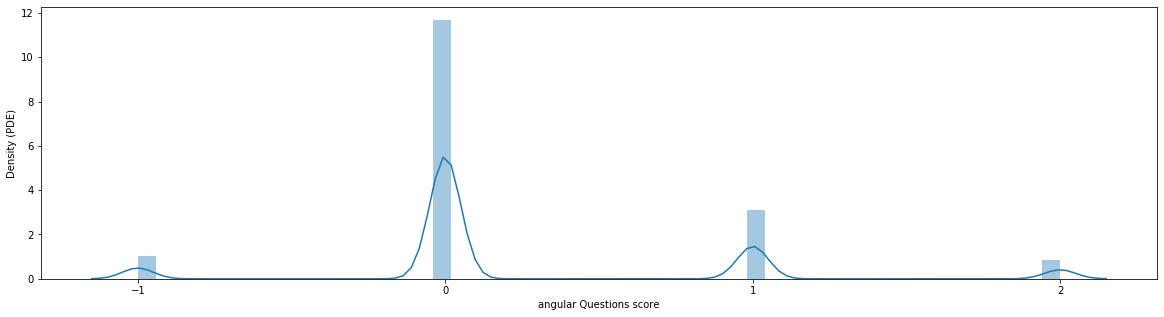

'ks_statistic = 0.43837017815260243, p_value = 0.0'
'No-outlier score distribution for angular answers'


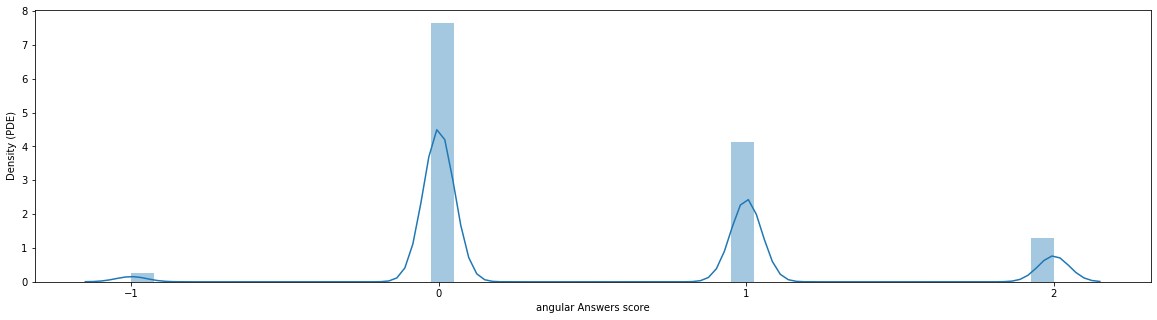

'ks_statistic = 0.48066283504324003, p_value = 0.0'


In [158]:
# required in this particular case as code debugging showed that the automatic KDE bandwidth selector (scotts method) 
# built into seaborn fails for this data

# the parameter controls smoothness of the KDE curve, testing revealed the following value to be not over/under smooth
kde_kws = {'bw': 0.05}

# Only show no-outlier plots (show_raw = False)
_analyze_metric_distribution(tag_2, metric, kde_kws, show_raw=False)

#### Observation
- Appears to be not-normal and ks-test verifies the same
- Same trend of halving in terms of probability density from 0 to 1, 2 and then -1
- Unlike reactjs range of scores remains same between questions and answers

### M1.3 Comparison on same plot

In [159]:
# Helper function to remove outliers and plot distributions on same plot
def compare_distributions(df, metric, x_label):
    upper_limit, lower_limit = get_outlier_limits_iqr(df, metric)
    no_outlier_df = df[(df[metric] > lower_limit) & (df[metric] < upper_limit)]
    
    g = sns.FacetGrid(no_outlier_df, hue="group_name", height=5, aspect= 3.33)
    
    # TODO, remove kde kws
    g = g.map(sns.distplot, metric,  hist=False, rug=False, kde_kws={'bw': 0.15})
    for ax_arr in g.axes:
        for ax in ax_arr:
            ax.set(ylabel='Density (PDE)')
            ax.set(xlabel=x_label)
    g.add_legend()

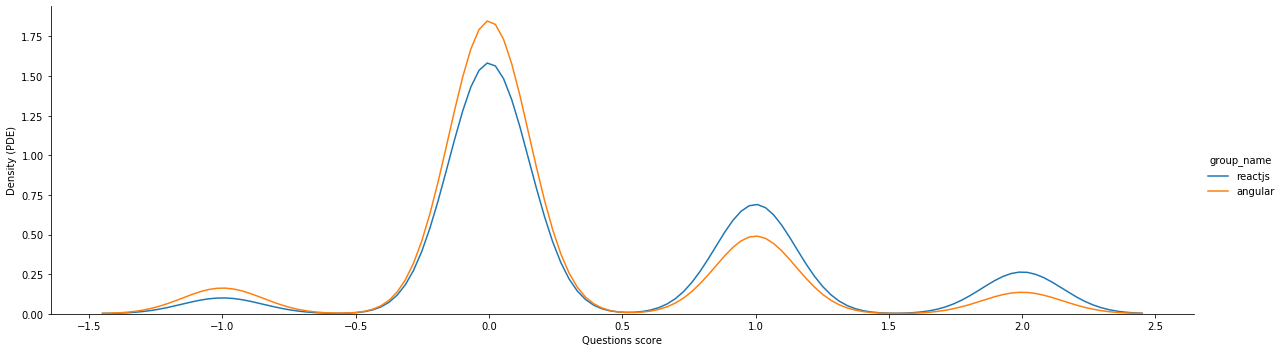

In [160]:
compare_distributions(dataframes['ques_df'], metric, f"Questions {metric}")

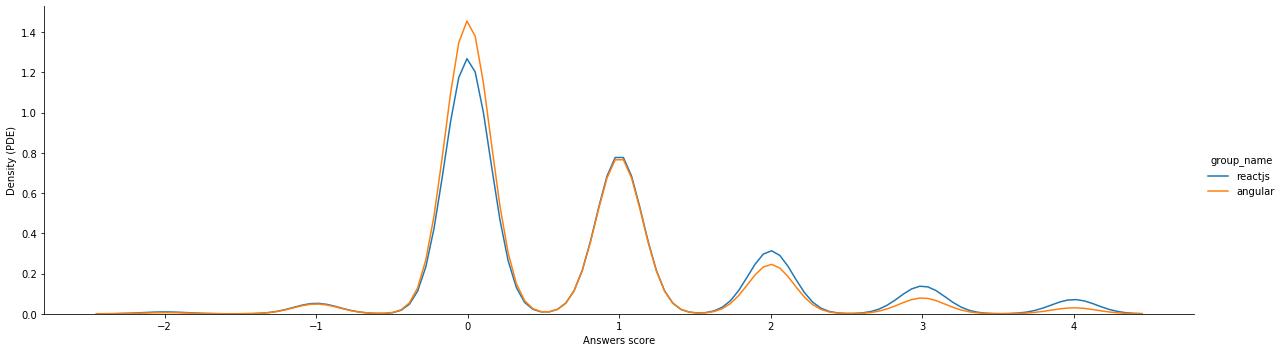

In [161]:
compare_distributions(dataframes['ans_df'], metric, f"Answers {metric}")

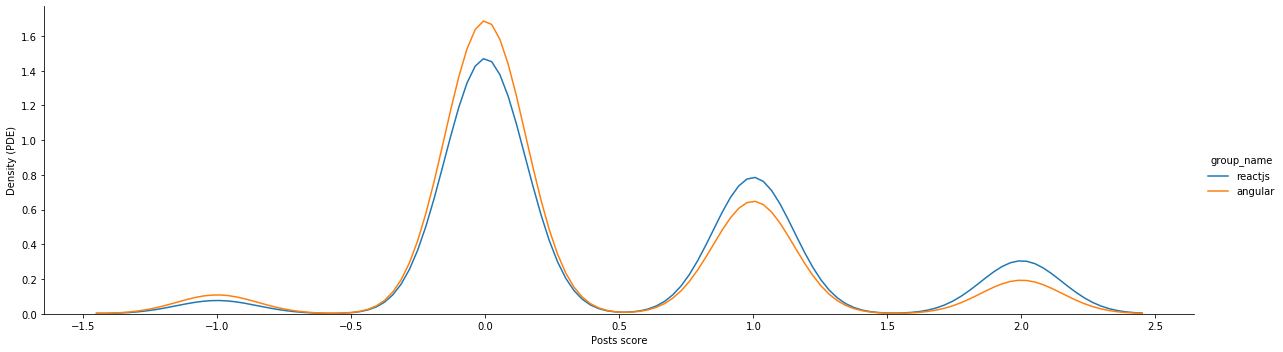

In [162]:
compare_distributions(dataframes['post_df'], metric, f"Posts {metric}")

#### Observations
- Angular posts have a significantly higher density of having 0 score whereas react posts have higher densities of higher scores
- In particular, the density of answer posts for scores +1 and -1 have identical probability density for both tags

#### Lets run the Mann-Whitney U Hypothesis test
Null hypothesis states that the distributions of two data sets are identical.
P-Value < 0.05 -> null hypothesis rejected -> verification that the distributions are different with statistical significance

In [163]:
def mann_whitney_u_test(distribution_1, distribution_2, data_type):
    u_statistic, p_value = stats.mannwhitneyu(distribution_1, distribution_2)
    pprint(f"{data_type}: u_statistic = {u_statistic}, p_value = {p_value}")
    return p_value < 0.05

In [164]:
mann_whitney_u_test(dataframes[f'{tag_1}_post_df'][metric], dataframes[f'{tag_2}_post_df'][metric], "posts")

'posts: u_statistic = 14045349954.0, p_value = 0.0'


True

In [165]:
mann_whitney_u_test(dataframes[f'{tag_1}_ques_df'][metric], dataframes[f'{tag_2}_ques_df'][metric], "questions")

'questions: u_statistic = 3140747936.0, p_value = 0.0'


True

In [166]:
mann_whitney_u_test(dataframes[f'{tag_1}_ans_df'][metric], dataframes[f'{tag_2}_ans_df'][metric], "answers")

'answers: u_statistic = 3947901333.0, p_value = 1.1531651359325578e-242'


True

The test p-values indicate that the distributions are different

#### Lets try scaling the data using standard scaler to observe if any new insight appear

In [167]:
scaler = StandardScaler()
ques_df_metric_scaled = scaler.fit_transform(dataframes['ques_df'][[metric]])
ans_df_metric_scaled = scaler.fit_transform(dataframes['ans_df'][[metric]])
post_df_metric_scaled = scaler.fit_transform(dataframes['post_df'][[metric]])

In [168]:
temp_ques_df = dataframes['ques_df'][["group_name"]]
temp_ques_df[metric] = ques_df_metric_scaled

temp_ans_df = dataframes['ans_df'][["group_name"]]
temp_ans_df[metric] = ans_df_metric_scaled

temp_post_df = dataframes['post_df'][["group_name"]]
temp_post_df[metric] = post_df_metric_scaled

C:\Users\muham\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\muham\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\muham\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

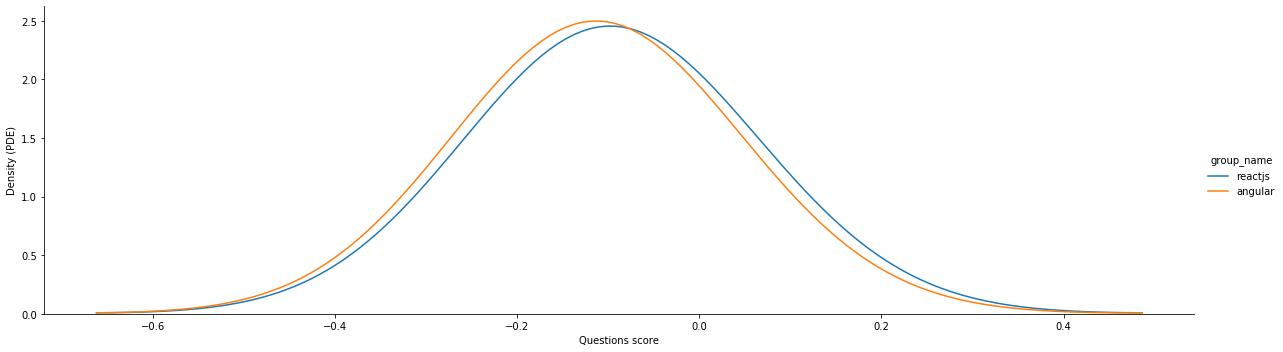

In [169]:
compare_distributions(temp_ques_df, metric, f"Questions {metric}")

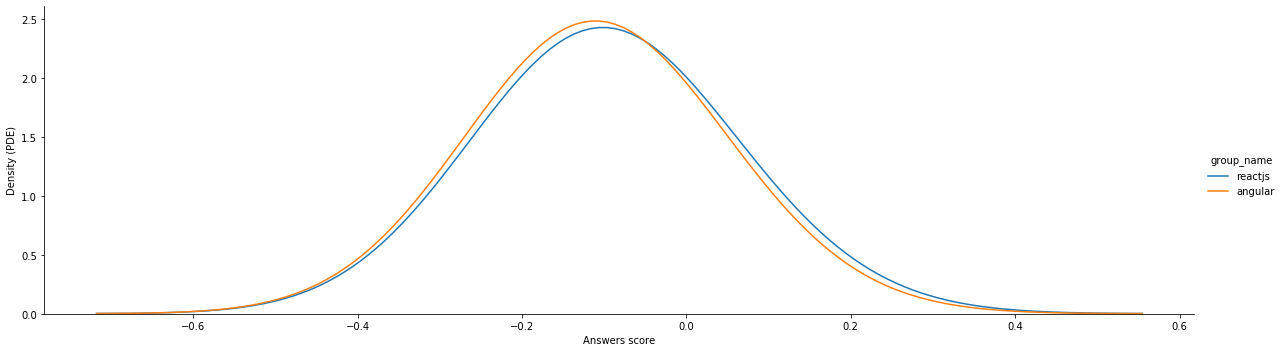

In [170]:
compare_distributions(temp_ans_df, metric, f"Answers {metric}")

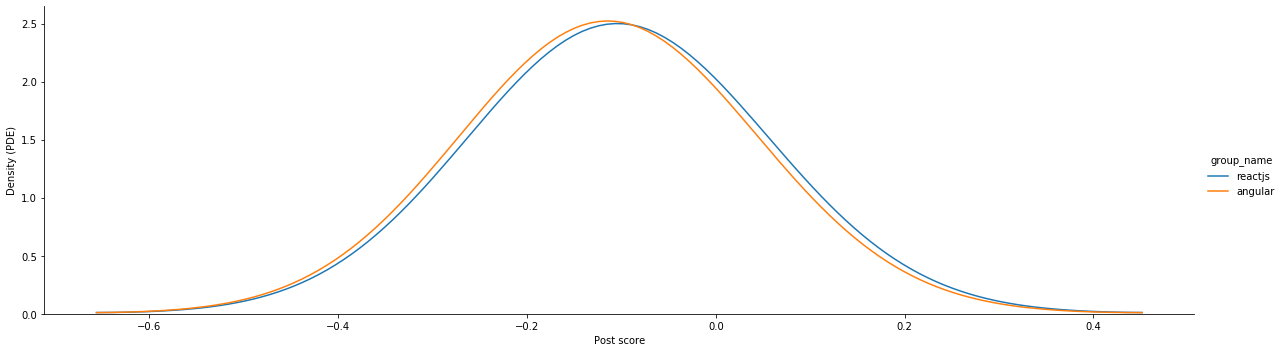

In [171]:
compare_distributions(temp_post_df, metric, f"Post {metric}")

###### For this analysis, rather than applying scaling, it appears to be more useful to interpret the distributions in their actual magnitude and unit of measure

### Metric 2: answer_count 

In [172]:
metric = "answer_count"

### M2.1 React

'No-outlier answer_count distribution for reactjs questions'


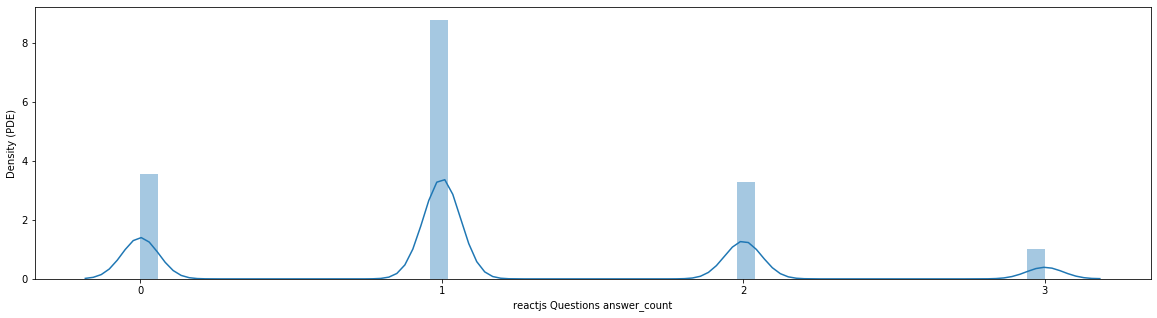

'ks_statistic = 0.6270930137859598, p_value = 0.0'


In [173]:
# Answer posts don't have an answer count (pass apply_on_ans = False)
# Only view clean distribution without outliers (show_raw = False)
_analyze_metric_distribution(tag_1, metric, apply_on_ans=False, show_raw=False)

##### Observation
- The probability density of 0 and 2 answer counts are quite similar.
- Most questions have 1 answer
- For most of the data (without outliers), answers range from 0 to 3
- Distribution is not normal

### M2.2 Angular

'No-outlier answer_count distribution for angular questions'


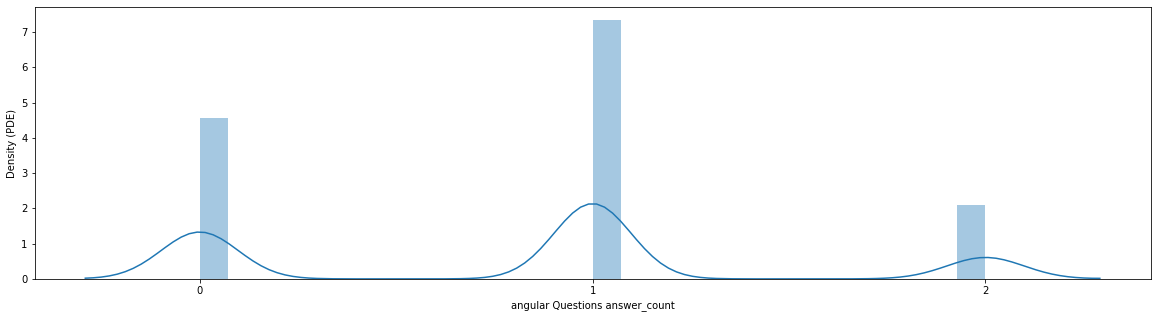

'ks_statistic = 0.5149684753815125, p_value = 0.0'


In [174]:
_analyze_metric_distribution(tag_2, metric, apply_on_ans=False, show_raw=False)

##### Observation
- Most questions have 1 answer
- For most of the data (without outliers), answers range from 0 to 2
- Distribution is not normal

### M2.3 Comparison

'questions: u_statistic = 3307469666.0, p_value = 0.0'


True

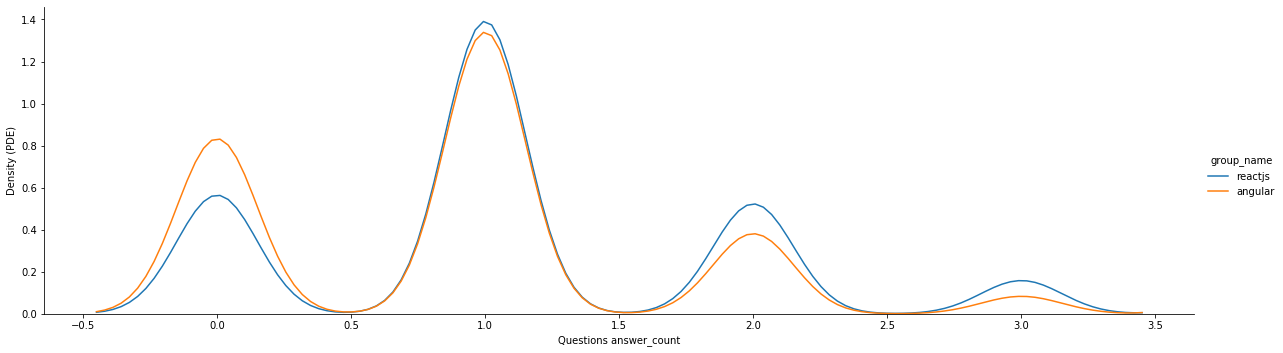

In [175]:
compare_distributions(dataframes['ques_df'], metric, f"Questions {metric}")
mann_whitney_u_test(dataframes[f'{tag_1}_ques_df'][metric], dataframes[f'{tag_2}_ques_df'][metric], "questions")

#### Observation
- React has higher density of answer_counts of 1+ on questions whereas angular has a significantly higher density of no answers on its questions 
- The probability density estimate for questions to have exactly 1 answer is close for react and angular whereas a sizable difference existings for other counts
- The u-test verifies that the distributions are different

### Metric 3: comment_count 

In [176]:
metric = "comment_count"

### M3.1 React

'No-outlier comment_count distribution for reactjs questions'


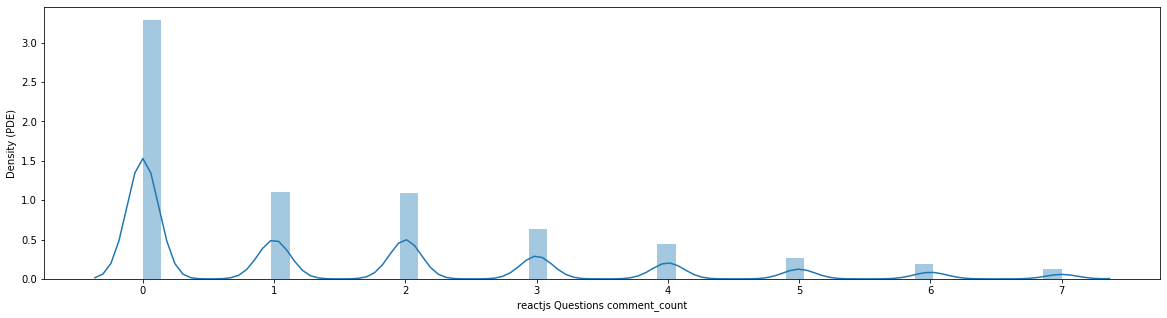

'ks_statistic = 0.5, p_value = 0.0'
'No-outlier comment_count distribution for reactjs answers'


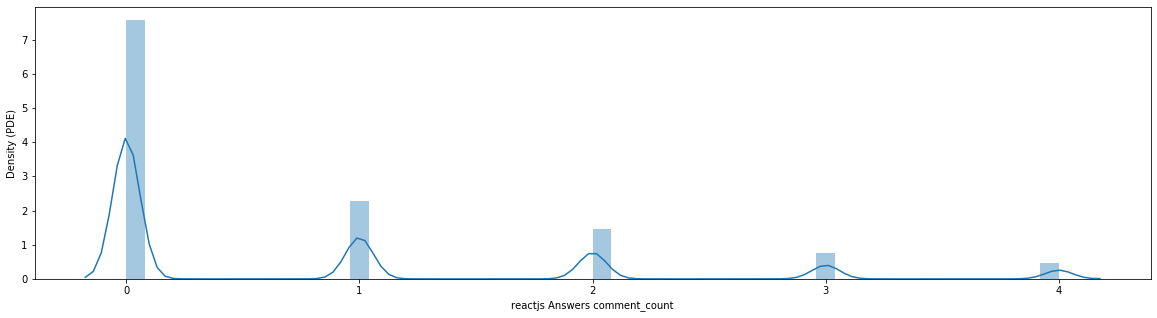

'ks_statistic = 0.5, p_value = 0.0'


In [177]:
# Only view clean distribution without outliers (show_raw = False)
_analyze_metric_distribution(tag_1, metric, show_raw=False)

##### Observation
- Unlike answer_count, questions and answers alike can have a larger range of comment_count
- Most questions and answers have no comments
- The probability density of reactjs questions having 1 or 2 comments are nearly identical
- Distribution is not normal

### M3.2 Angular

'No-outlier comment_count distribution for angular questions'


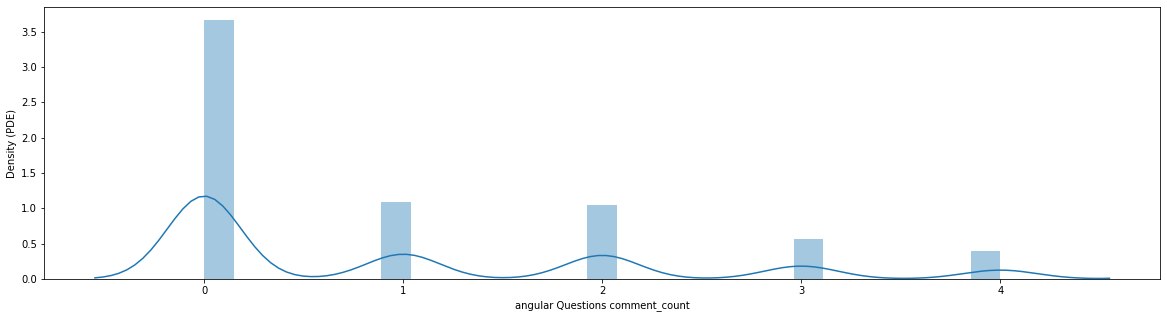

'ks_statistic = 0.5, p_value = 0.0'
'No-outlier comment_count distribution for angular answers'


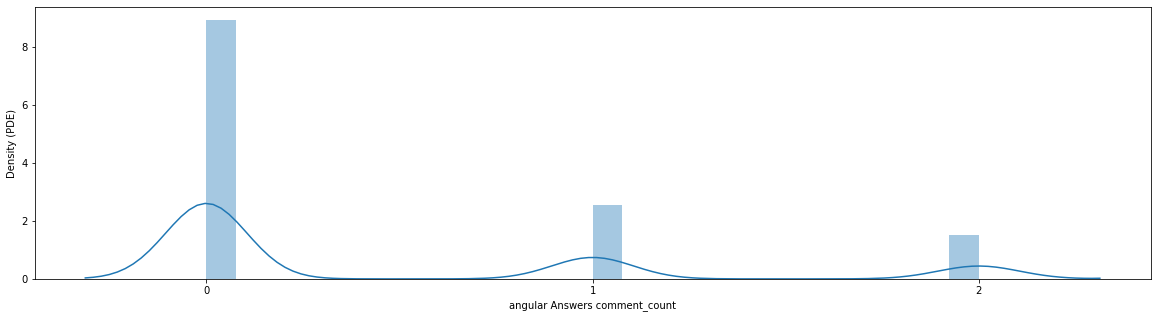

'ks_statistic = 0.5, p_value = 0.0'


In [178]:
_analyze_metric_distribution(tag_2, metric, show_raw=False)

##### Observation
- Unlike react fewer range of values for comment_count across questions and answers
- Most questions and answers have no comments
- Distribution is not normal

### M3.3 Comparison

'questions: u_statistic = 3694269346.5, p_value = 5.915479755679501e-51'
'answers: u_statistic = 4434880792.0, p_value = 1.1750754419940698e-10'
'posts: u_statistic = 16468994300.5, p_value = 6.178379729619408e-30'


True

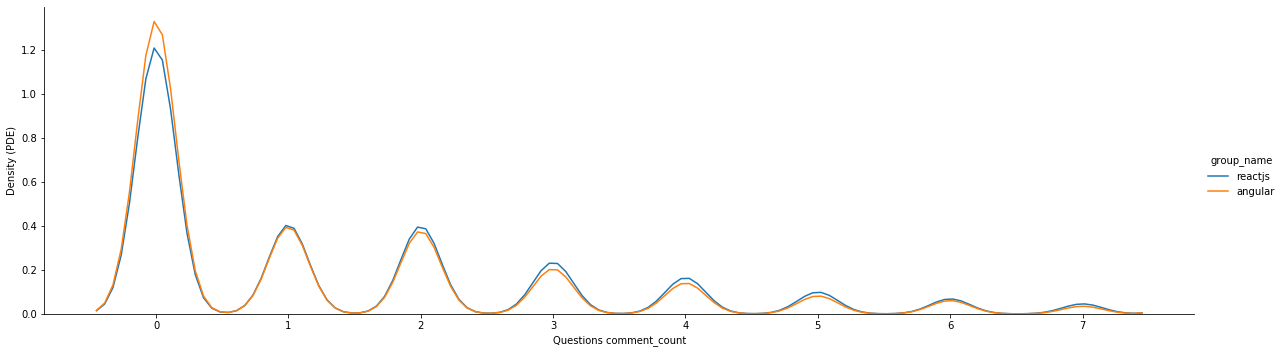

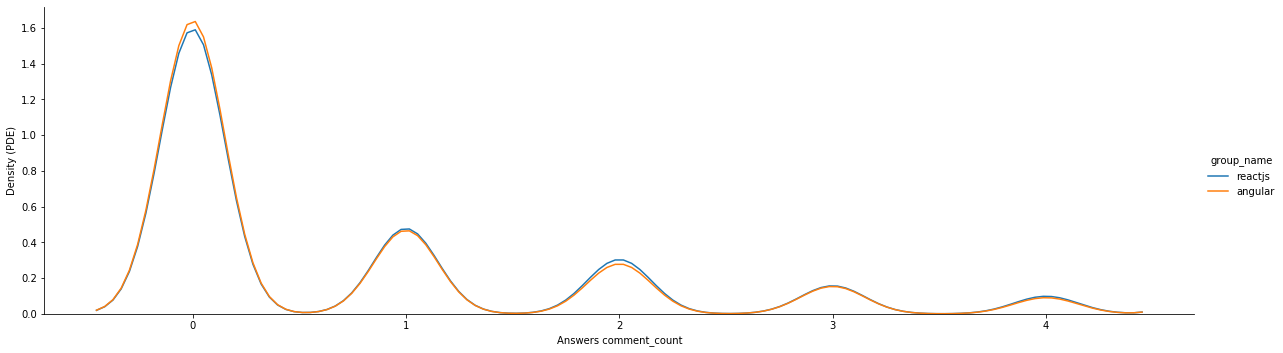

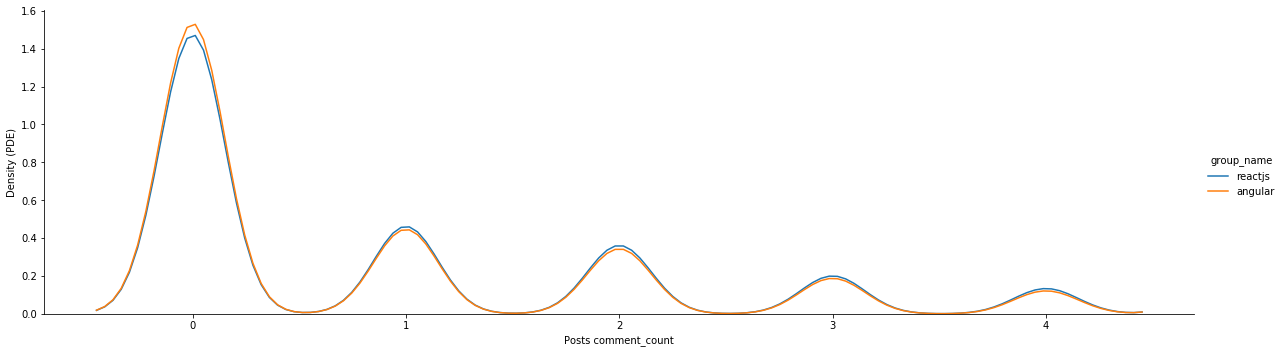

In [179]:
compare_distributions(dataframes['ques_df'], metric, f"Questions {metric}")
mann_whitney_u_test(dataframes[f'{tag_1}_ques_df'][metric], dataframes[f'{tag_2}_ques_df'][metric], "questions")

compare_distributions(dataframes['ans_df'], metric, f"Answers {metric}")
mann_whitney_u_test(dataframes[f'{tag_1}_ans_df'][metric], dataframes[f'{tag_2}_ans_df'][metric], "answers")

compare_distributions(dataframes['post_df'], metric, f"Posts {metric}")
mann_whitney_u_test(dataframes[f'{tag_1}_post_df'][metric], dataframes[f'{tag_2}_post_df'][metric], "posts")

#### Observation
- The probability density of angular for having 0 comments on posts is significantly higher than react, whereas react is >= angular for 1 or higher comment_count

### Metric 4: view_count 

In [180]:
metric = "view_count"

### M4.1 React

'No-outlier view_count distribution for reactjs questions'


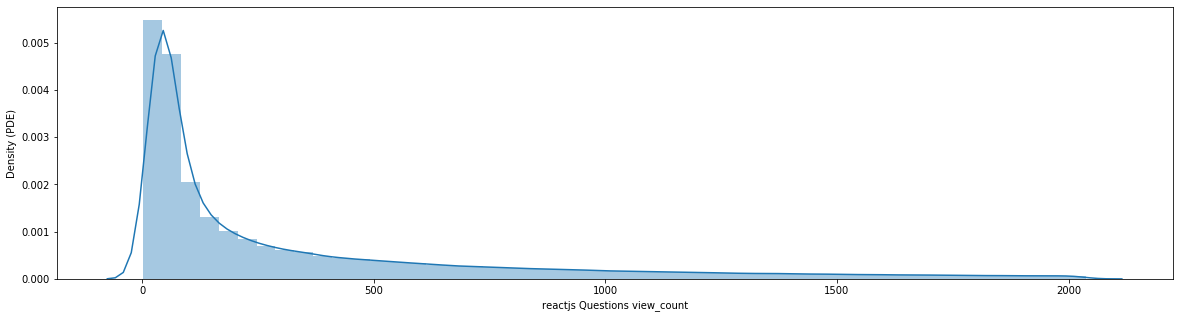

'ks_statistic = 0.9999402044612743, p_value = 0.0'


In [181]:
# view_count as a metric is not record for answer posts as they are always viewed on the same page as their respective question
# Only view clean distribution without outliers (show_raw = False)
_analyze_metric_distribution(tag_1, metric, apply_on_ans=False, show_raw=False, xticks_arr=[])

##### Observation
- Majority of react questions have the lowest "bin" of view_count, the peak of the distribution is close to the left (right-skewed)

### M4.2 Angular

'No-outlier view_count distribution for angular questions'


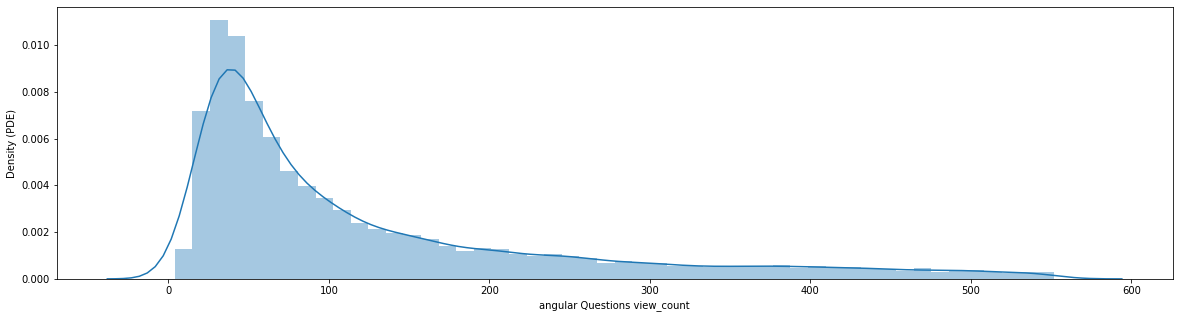

'ks_statistic = 0.9999683287581669, p_value = 0.0'


In [182]:
_analyze_metric_distribution(tag_2, metric,  apply_on_ans=False, show_raw=False, xticks_arr=[])

##### Observation
- Angular questions have a significantly higher viewership than react questions despite react having generally higher comment_count, answer_count and scores 
- Majority of angular questions have a "middle bin" of view_count, the peak of the distribution is close to the left (right-skewed) but less skewed than react

### M4.3 Comparison

'questions: u_statistic = 2989113143.0, p_value = 0.0'


True

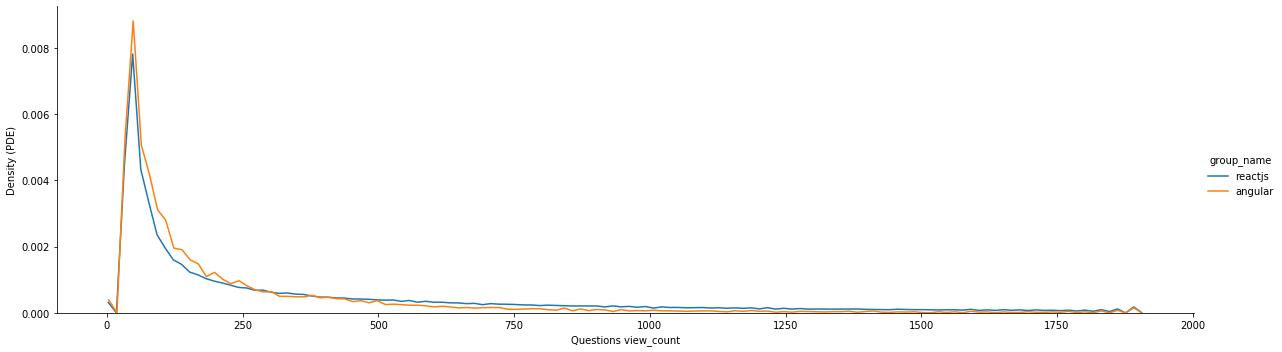

In [183]:
compare_distributions(dataframes['ques_df'], metric, f"Questions {metric}")
mann_whitney_u_test(dataframes[f'{tag_1}_ques_df'][metric], dataframes[f'{tag_2}_ques_df'][metric], "questions")

#### Observation
- For lower view_counts, angular questions have a higher density of views however for higher ones (~>400 view_count), react has higher viewership

### Metric 5: time_to_accepted_answer 

In [184]:
metric = "time_to_accepted_answer"

### M5.1 React

'Raw time_to_accepted_answer distribution for reactjs questions'


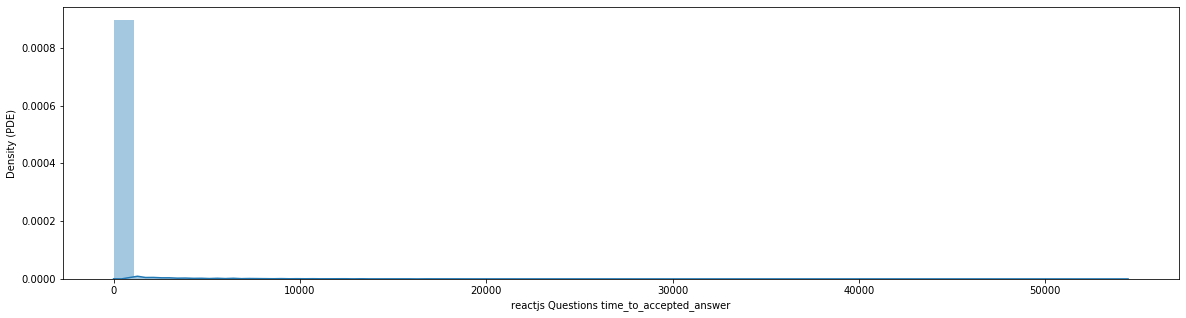

'No-outlier time_to_accepted_answer distribution for reactjs questions'


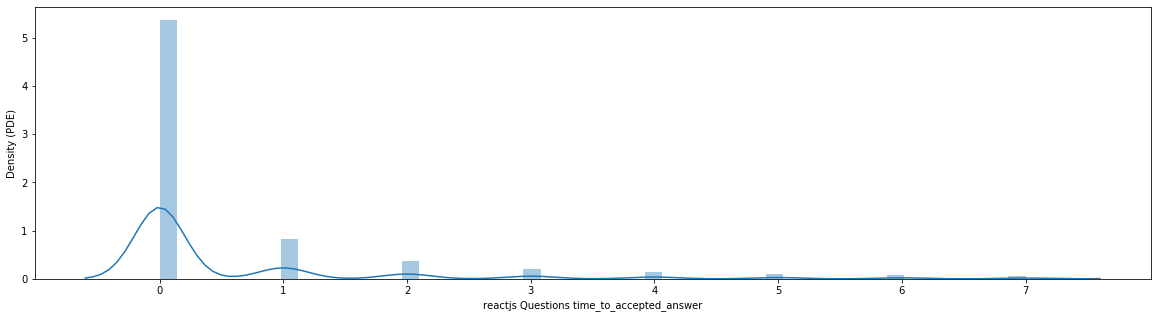

'ks_statistic = 0.5, p_value = 0.0'


In [185]:
# time_to_accepted_answer as a metric is only for question posts
# Only view clean distribution without outliers (show_raw = False)

# smoothness value reached via testing
kde_kws = {'bw': 0.20}
_analyze_metric_distribution(tag_1, metric, kde_kws, apply_on_ans=False, show_raw=True)

##### Observation
- For react questions which have accepted answers, highest density and frequency count puts the time to accepted answer creation to be within 1 hour of posting the question
- For most values (without outliers), the range is from 0 to ~ 7.5 hours (~ 1 work day)


### M5.2 Angular

'Raw time_to_accepted_answer distribution for angular questions'


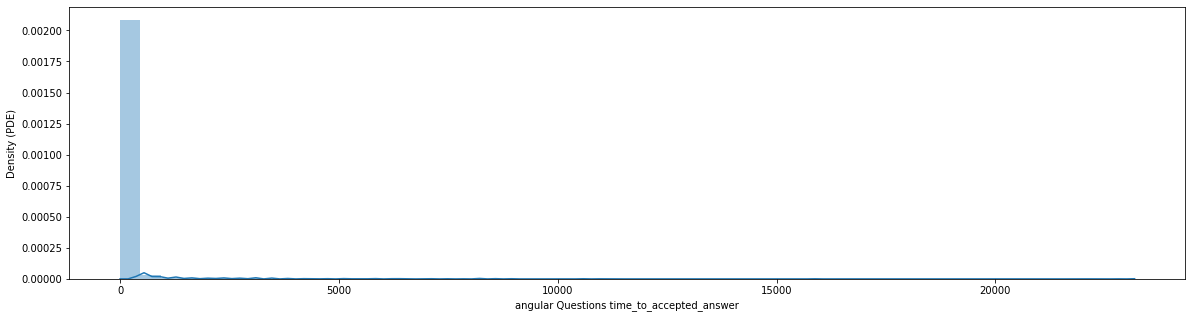

'No-outlier time_to_accepted_answer distribution for angular questions'


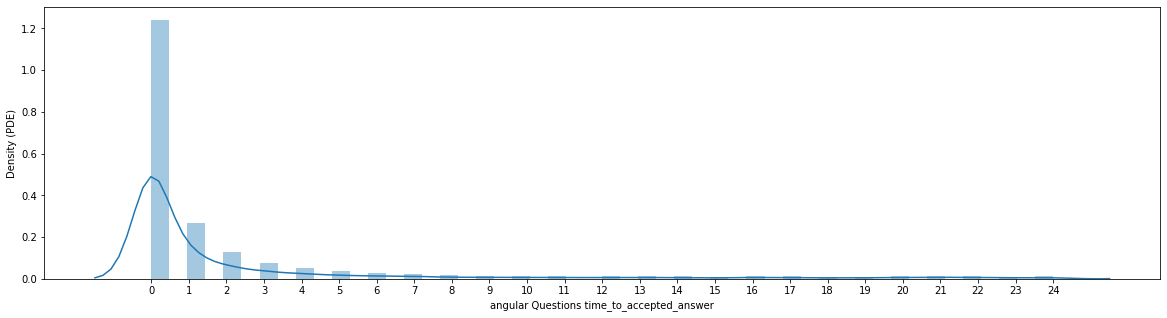

'ks_statistic = 0.5, p_value = 0.0'


In [186]:
kde_kws = {'bw': 0.5}
_analyze_metric_distribution(tag_2, metric, kde_kws, apply_on_ans=False, show_raw=True)

##### Observation
- For angular questions which have accepted answers, highest density and frequency count puts the time to accepted answer creation to be within 1 hour of posting the question
- For most values (without outliers), the range is from 0 to ~ 25 hours (~ 1 full day)

### M5.3 Comparison

'questions: u_statistic = 3449207446.5, p_value = 1.061007027613328e-195'


True

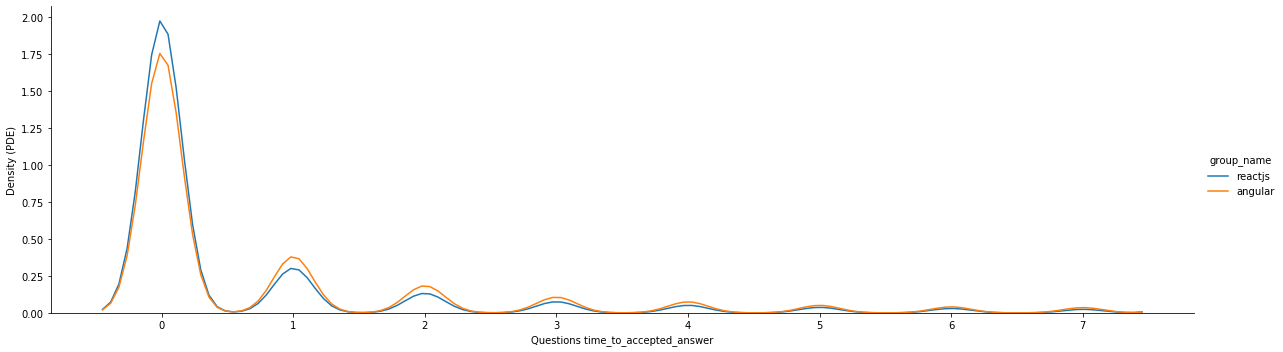

In [187]:
compare_distributions(dataframes['ques_df'], metric, f"Questions {metric}")
mann_whitney_u_test(dataframes[f'{tag_1}_ques_df'][metric], dataframes[f'{tag_2}_ques_df'][metric], "questions")

#### Observation
- For questions with accepted answers created within 1 hour, react is significantly more dense however for all subsequent hours values angular is more dense.

# Additional Analysis - Metric Correlation

In [188]:
metrics = ["score","answer_count", "comment_count", "view_count", "time_to_accepted_answer"]
tag_1_metric_df = analysis_dataset_tag_1[metrics]
tag_2_metric_df = analysis_dataset_tag_2[metrics]

tag_1_pearson_corr_matrix = tag_1_metric_df.corr(method="pearson")
tag_2_pearson_corr_matrix = tag_2_metric_df.corr(method="pearson") 

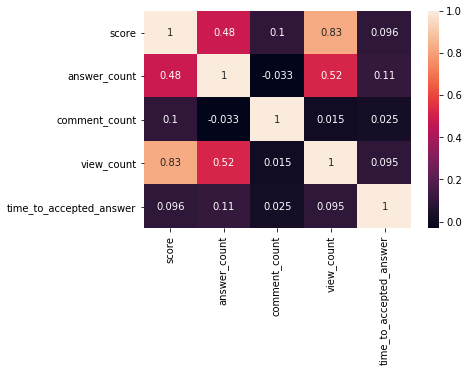

In [189]:
sns.heatmap(tag_1_pearson_corr_matrix, annot=True)
plt.show()

#### Observation
- For react, all metrics have a positive correlation except (comment_count, answer_count) with weak negative correlation
- The strongest positive correlation is between (score, view_count) followed by (answer_count, view_count)

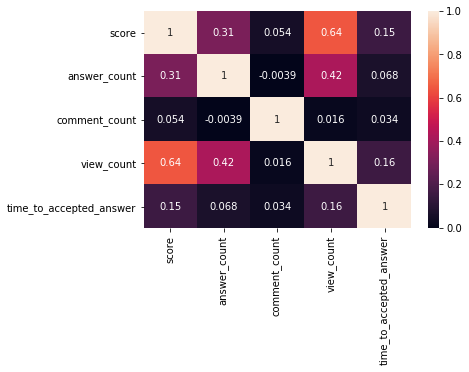

In [190]:
sns.heatmap(tag_2_pearson_corr_matrix, annot=True)
plt.show()

#### Observation
- For angular all metrics have a positive correlation except (answer_count, comment_count) with a weak negative correlation
- The strongest positive correlation is between (score, view_count) followed by (answer_count, view_count)

#### Comparison
- Overall stronger positive correlations are observed across all metrics in react over angular. Particularly, the score of a post of react has a stronger impact on its view_count than in angular. 
- For both technologies, the strongest positive correlation is between (score, view_count) followed by (answer_count, view_count) 